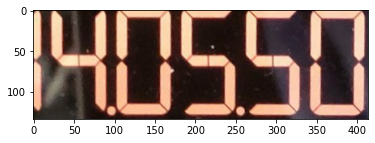

In [73]:
import cv2 as cv
import myutils as my
import matplotlib.pyplot as plt
import numpy as np

img = cv.imread("balance.jpg")
# 创建列表locs储存轮廓的形状坐标，列表cnts储存lunkuo
locs = []
cnts = []
thresh, contours = my.preprocess(img)
# 遍历每个轮廓，根据面积找出数字界面
for (i, c) in enumerate(contours):
    # 计算矩形
    x, y, w, h = cv.boundingRect(c)
    area = cv.contourArea(c)
    # print(area)
    # 符合的留下来
    if 47000 > area > 46000:
        locs.append((x, y, w, h))
        cnts.append(c)
# print(len(np.array(cnts)))
# 求ROI
roi = img[locs[0][1]:locs[0][1] + locs[0][3],
          locs[0][0]:locs[0][0] + locs[0][2]]
# my.cv_show('roi', roi)

plt.imshow(roi)
plt.show()


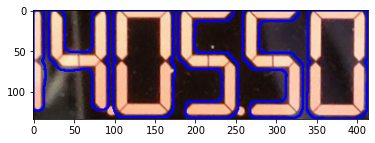

In [74]:

roi_gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
# my.cv_show('roi_gray', roi_gray)
roi_thresh = cv.threshold(roi_gray, 0, 255,
                          cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
# my.cv_show('roi_thresh', roi_thresh)

roi_median = cv.medianBlur(roi_thresh, 5)  # 中值滤波
i = 0
while i < 13:
    roi_median = cv.medianBlur(roi_median, 5)
    i += 1
# my.cv_show('roi_median', roi_median)

kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))  # 矩形结构
roi_dilation = cv.dilate(roi_median, kernel)  # 膨胀
roi_dilation = cv.dilate(roi_dilation, kernel)  # 膨胀
# my.cv_show('dilation', roi_dilation)

# 提取小轮廓，即每个数字
roi_contours = cv.findContours(roi_dilation.copy(), cv.RETR_EXTERNAL,
                               cv.CHAIN_APPROX_SIMPLE)[0]
roi_contours = my.sort_contours(roi_contours, method="left-to-right")[0]

roi_cnts = [] 
for (i, c) in enumerate(roi_contours):
    # 计算矩形
    x, y, w, h = cv.boundingRect(c)
    perimeter = cv.arcLength(c, True)
    if perimeter > 250:
        roi_cnts.append(c)

roi_copy = roi.copy()
cv.drawContours(roi_copy, roi_cnts, -1, (0, 0, 255), 2)
plt.imshow(roi_copy)
plt.show()


In [75]:
groupOutput = [] # 储存了5位数字输出
for (i, c) in enumerate(roi_cnts):  
    (x, y, w, h) = cv.boundingRect(c)
    roi_number = roi[y:y + h, x:x + w]
    roi_number = cv.resize(roi_number, (57, 88))
    groupOutput.append(roi_number)
    # plt.imshow(roi_number)
    # plt.show()

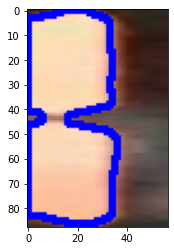

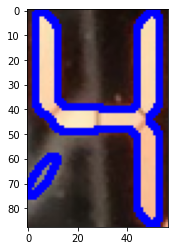

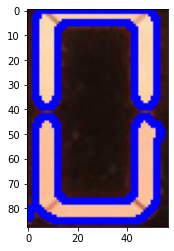

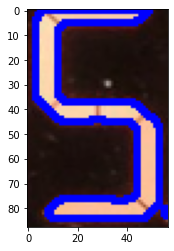

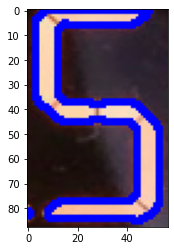

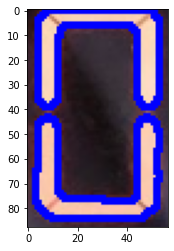

['1', '4', '0', '5', '5', '0']


In [76]:

groupOutput_correct = []
result = []
for (i, c) in enumerate(groupOutput): # 在每幅图中遍历，一共6幅图
    gray = cv.cvtColor(c, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(gray, 0, 255,
                          cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    median = cv.medianBlur(thresh, 5)
    contours = cv.findContours(median.copy(), cv.RETR_EXTERNAL,
                               cv.CHAIN_APPROX_SIMPLE)[0]
    c_copy = c.copy()
    cv.drawContours(c_copy, contours, -1, (0, 0, 255), 2)

    for (i,c) in enumerate(contours):
        area = cv.contourArea(c)
        if area >100 :
            groupOutput_correct.append(c)

    if len(groupOutput_correct) > 1: #数字 0
        number = '0'
        result.append(number)
    else:
        M = cv.moments(groupOutput_correct[0])
        cx, cy = M['m10'] / M['m00'], M['m01'] / M['m00']  
        # print(f'centel point is {cx},{cy}')
        if  15.5<cx<17.5 and 42.5<cy<43.5:
            number = '1'
        elif 32.5<cx<33.5 and 37.5<cy<38.5:
            number = '4'
        elif 26<cx<28 and 42<cy<44:
            number = '5'
        result.append(number)
    groupOutput_correct.clear()
    plt.imshow(c_copy)
    plt.show()
    
print(result)